# Homework 4: Conversation Modeling and decoding

# Part 1 Modeling

## 1.1 Attention visulization

In [0]:
### set up the model and complete the corresponding task

### the pretrained model was trained in ~2 hours, i.e. you can expect attention maps
### to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

### You present here:

In [0]:
# this is some example attention map here, 
# *make sure you add text tokens on the axes to make it readable!*

![Imgur](https://i.imgur.com/xodciCU.png)

## 1.2 Encoder Transformer

In [0]:
### add transformer encoder as optional encoder in seq2seq model.

# code below can help you to start it, but feel free to start from scratch

class EncoderTransformer(nn.Module):
     def __init__(self):
        
        # you need to add more things here
        
        self.position_embed = nn.Embedding()
        encoder_layer = nn.TransformerEncoderLayer()
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

    def forward(self, text_vec):
        # some helpful directions below, check the MLM lab for more details
        
        # embedded = pos_embedded + embedded  # apply pos embedding
        # attention_mask = ...
        # output = self.transformer(embedded, src_key_padding_mask=attention_mask)
        return None
        

## You present here:

In [0]:
# check pdf to see what you expected to present

# Part 2 Decoding

# 2.1 Nucleus Sampling

In [0]:
import re
from collections import Counter
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import torch

In [0]:
class ChatDictionary(object):
    """
    Simple dict loader
    """
    def __init__(self, dict_file_path):
        self.word2ind = {}  # word:index
        self.ind2word = {}  # index:word
        self.counts = {}  # word:count

        dict_raw = open(dict_file_path, 'r').readlines()
        
        for i, w in enumerate(dict_raw):
            _word, _count = w.strip().split('\t')
            if _word == '\\n':
                _word = '\n'
            self.word2ind[_word] = i
            self.ind2word[i] = _word
            self.counts[_word] = _count
            
    def t2v(self, tokenized_text):
        return [self.word2ind[w] if w in self.counts else self.word2ind['__unk__'] for w in tokenized_text]

    def v2t(self, list_ids):
        return ' '.join([self.ind2word[i] for i in list_ids])
    
    def pred2text(self, tensor):
        result = []
        for i in range(tensor.size(0)):
            if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
                break
            else:
                result.append(self.ind2word[tensor[i].item()])
        return ' '.join(result)
    
    def __len__(self):
        return len(self.counts)

In [0]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)
class ChatDataset(Dataset):
    """
    Json dataset wrapper
    """
    
    def __init__(self, dataset_file_path, dictionary, dt='train'):
        super().__init__()
        
        json_text = open(dataset_file_path, 'r').readlines()
        self.samples = []
        
        for sample in tqdm(json_text):
            sample = sample.rstrip()
            sample = json.loads(sample)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            # train and valid have different key names for target
            if dt == 'train':
                _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            elif dt == 'valid':
                _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
                
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)

In [0]:
def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t)
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths

def argsort(keys, *lists, descending=False):
    """Reorder each list in lists by the (descending) sorted order of keys.
    :param iter keys: Keys to order by.
    :param list[list] lists: Lists to reordered by keys's order.
                             Correctly handles lists and 1-D tensors.
    :param bool descending: Use descending order if true.
    :returns: The reordered items.
    """
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output

def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packinng
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, input_lens, label_vecs, label_lens, descending=True)

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
        'use_packed': True
    }

In [6]:
# loading datasets and dictionary

# downloading pretrained models and data

### DOWNLOADING THE FILES
import os

### persona chat dataset
if not os.path.exists('./dict'):
    !wget "https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h" -O './dict'
if not os.path.exists('./train.jsonl'):
    !wget "https://nyu.box.com/shared/static/aqp0jyjaixjmukm5asasivq2bcfze075.jsonl" -O './train.jsonl'
if not os.path.exists('./valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/eg4ivddtqib2hkf1k8rkxnmzmo0cq27p.jsonl" -O './valid.jsonl'

if not os.path.exists('./chat_model_best_22.pt'):
    !wget "https://nyu.box.com/shared/static/24zsynuks8nzg7530tgakzh8o62id9xa.pt" -O './chat_model_best_22.pt'

chat_dict = ChatDictionary('./dict')
train_dataset = ChatDataset('./train.jsonl', chat_dict)
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')

--2019-11-12 23:33:20--  https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h
Resolving nyu.box.com (nyu.box.com)... 107.152.27.197, 107.152.26.197
Connecting to nyu.box.com (nyu.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/sj9f87tofpicll89xbc154pmbztu5q4h [following]
--2019-11-12 23:33:25--  https://nyu.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h [following]
--2019-11-12 23:33:25--  https://nyu.app.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.26.199, 107.152.27.199
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.26.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxclo

100%|██████████| 7801/7801 [00:00<00:00, 8771.09it/s]


In [0]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=256)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=256)

In [0]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        attention_mask = text_vec.ne(self.pad_idx) # ne function calculates not equal to element-wise
        
        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
        output, hidden = self.gru(embedded, hidden)
        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
        
        return output, hidden, attention_mask

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((~attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = True
    
if load_pretrained is True:
    if current_device == 'cuda':
        model_pt = torch.load('./chat_model_best_22.pt')
    else:
        model_pt = torch.load('./chat_model_best_22.pt', map_location=torch.device('cpu'))
    opts = model_pt['opts']
    
    model = seq2seq(opts)
    model.load_state_dict(model_pt['state_dict'])
    model.to(current_device)

In [0]:
# implement nucleus sampling here.
# you must cite any code you use from other sources!
import numpy as np

def nucleus_sampling(model, batch, batch_size, prob_thre):
    """
    batch: the input batch which we want to sample the output on
    batch_size: the relative batch size
    prob_thre: the probability threshold to choose top p next token
    """
    model.eval()
    with torch.no_grad():
        text_vecs = batch['text_vecs'].to(current_device)
        encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
        encoder_output, encoder_hidden, attention_mask = encoded

        # First define __start__ as the starting point of our sampling
        starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        decoder_hidden = encoder_hidden

        # Start sampling
        samp = [starts]
        probs_selecting = []

        # We want to stop when every sequence has 2 as their ends (2 == __end__)
        finish_mask = torch.Tensor([0]*batch_size).byte().to(model.decoder.embedding.weight.device)
        current_sequences = starts
        _attn_w_log = []

        def find_indices(sorted_prob, prob_thre): 
            # Given a sorted probs, return the number of probs and sum of probs that could add up to >= threshold     
            sum_now = 0
            count = 0
            while sum_now < prob_thre:
                sum_now += sorted_prob[count].item()
                count += 1
            return count, sum_now

        for time_step in range(1000):
            decoder_output, decoder_hidden, attn_w_log = model.decoder(current_sequences, decoder_hidden, encoded)
            all_probs = torch.softmax(decoder_output, dim=-1)
            new_samp_all = []
            new_prob_list = []
            for i in range(batch_size):
                single_next = all_probs[i, :, :].squeeze()
                _probs, _indices = torch.sort(single_next, descending=True)
                count, sum_p = find_indices(_probs, prob_thre)
                new_probs = _probs[:count] / sum_p
                _indices = _indices[:count]
                # Now sample an index from the new conditional distribution
                new_pred = _indices[torch.multinomial(new_probs, 1)].view(-1, 1).long()
                prob_for_this_token = _probs[new_pred.item()].view(-1, 1)
                #new_pred = torch.Tensor([np.random.choice(_indices, p = _probs)]).view(-1, 1).long()
                new_samp_all.append(new_pred)
                new_prob_list.append(prob_for_this_token)

            _samp = torch.cat(new_samp_all, dim=1).to(model.decoder.embedding.weight.device)
            prob_batch = torch.cat(new_prob_list, dim=1).to(model.decoder.embedding.weight.device)
            samp.append(_samp)
            probs_selecting.append(prob_batch)
            _attn_w_log.append(attn_w_log)

            finish_mask += (_samp == 2).byte().view(-1)
            
            if not (torch.any(~finish_mask.bool())): # ~ is invert
                break
            
            current_sequences = _samp
        
        samp = torch.cat(samp, dim=-1)
        probs_selecting = torch.cat(probs_selecting, dim=-1)
            
    return samp, probs_selecting

In [11]:
# A test run
inputs = RETOK.findall("your persona: i live in texas.\n hello , where are you ? ?")

test_batch = {
    'text_vecs': torch.tensor([chat_dict.t2v(inputs)], dtype=torch.long, device=model.decoder.embedding.weight.device),
    'text_lens': torch.tensor([len(inputs)], dtype=torch.long),
    'use_packed': True,
}

sample, probs = nucleus_sampling(model, test_batch, 1, 0.1)#.tolist()
print(chat_dict.v2t(*sample.tolist()))
print(np.average(np.log(probs.tolist())))

__start__ i am from california , where are you from ? __end__
-7.423248277044979


## You present here:

Our input is: your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ?


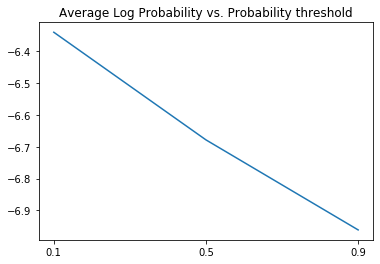

In [77]:
# Section 2.1
# Q2 and Q3
import matplotlib.pyplot as plt

number_decodings = 100
prob_thre_list = [0.1, 0.5, 0.9]
# Selecting a single input from the validation set
index = 0
valid_input = valid_dataset[index][0]
print(f"Our input is: {chat_dict.v2t(valid_input.tolist())}")
test_input = {
    'text_vecs': valid_input.view(1, -1).to(model.decoder.embedding.weight.device),
    'text_lens': torch.tensor([len(valid_input)], dtype=torch.long),
    'use_packed': True,
}

# Compute the average log-probability of generated sequences for each value of prob_thre
# Also store the samples
log_p_dict = {}
all_samples = {}
for thre in prob_thre_list:
    log_p_dict[thre] = []
    all_samples[thre] = []
    for i in range(number_decodings):
        sample, probs = nucleus_sampling(model, test_input, 1, thre)
        # Store the sample
        all_samples[thre].append(*sample.tolist())
        # Compute log_p and add them up
        log_p_total = torch.mean(torch.log(probs))
        log_p_dict[thre].append(log_p_total)

avg_log_p = [np.mean(log_p_dict[i]) for i in log_p_dict]
plt.plot(prob_thre_list, avg_log_p)
plt.title("Average Log Probability vs. Probability threshold")
plt.xticks([0.1, 0.5, 0.9])
plt.show()

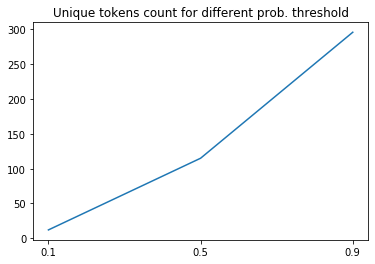

In [78]:
# Q3's plot
unique_token_count = []
for thre in all_samples:
    all_tokens = []
    [all_tokens.extend(l) for l in all_samples[thre]]
    unique_token_count.append(len(set(all_tokens)))

# Plot
plt.plot(prob_thre_list, unique_token_count)
plt.title("Unique tokens count for different prob. threshold")
plt.xticks([0.1, 0.5, 0.9])
plt.show()

## 2.2 N-Gram blocking

In [0]:
# implement n-gram blocking
# carefully read instructions in pdf

# we give you some small hint code here which can be helpful

l = [1,2,3,4,5,6,4,5,6]

history = tuple(l[-2:])

print(history)

banned = []

for ngram in zip(*[l[i:] for i in range(3)]):
    if ngram[:-1] == history:
        banned.append(ngram[-1])
        
print(banned)

(5, 6)
[4]


## You present here:

In [0]:
# check pdf to see what you expected to present

# Part 3 Interactive chat

In [0]:
# implement logic for interactive chat here
# the easiest is to just use python input functionality

def transfer(input):
    # Transfer an input to a tensor
    _inp_tokened = RETOK.findall(input)
    _inp_tokened_id = chat_dict.t2v(_inp_tokened)
    tensor_input = torch.tensor(_inp_tokened_id, dtype=torch.long)
    return tensor_input

def make_it_batch(model, input_tensor):
    # Make a input tensor a batch
    device_now = model.decoder.embedding.weight.device
    return {
        'text_vecs': input_tensor.view(1, -1).to(device_now),
        'text_lens': torch.tensor([len(input_tensor)], dtype=torch.long),
        'use_packed': True}

def logging(chat_history):
    print("\n")
    print("Here's the full dialog history")
    print(chat_dict.v2t(chat_history.tolist()))
    return None

# Now we start to implement chat function
def chat(model, chat_history, start = True):
    new_input = input("What do you want to say next\n")
    if new_input == "": # If the user don't want to continue the chat
        logging(chat_history)
        return None
    else:
        if start:
            chat_history = transfer(chat_history)
        new_line_id = torch.tensor(chat_dict.t2v(["\n"]), dtype=torch.long)
        # Add user's input to chat history
        # TODO
        chat_history = torch.cat([chat_history, new_line_id, transfer(new_input)])
        # Now do the sampling
        input_for_samp = make_it_batch(model, chat_history)
        output, probs = nucleus_sampling(model, input_for_samp, 1, 0.5)
        output = output.squeeze()[1:-1]
        print(f"The model says: {chat_dict.v2t(output.tolist())} \n")
        new_chat = torch.cat([chat_history, new_line_id, output])
        return chat(model, new_chat, start = False)


## You present here:

In [16]:
# Dialogue sample
# First pick a persona
index = 20
sample = valid_dataset[index][0]
persona_list = chat_dict.v2t(sample.tolist()).split("\n")
persona = ""
for item in persona_list:
    if "your persona" in item:
        persona += item
        persona += "\n"

# If we want to self input persona, uncooment next line        
# persona = "your persona: i am from china.\nyour persona: i currently live in jersey.\nyour persona: i come from a small town.\nyour persona: my favorite drink is coke.\nyour persona: i am very bad at homework."
chat(model, persona)

What do you want to say next
hi, where do you live?
The model says: i live in the mountains so i ' m a country trainer 

What do you want to say next
do you like climb mountains?
The model says: i do not . i am not sure about them 

What do you want to say next
where are you from?
The model says: i am from new york city 

What do you want to say next
how many children do you have?
The model says: i have three kids , and you ? 

What do you want to say next
I do not have any kids. do you like school?
The model says: i do . what do you do for a living ? 

What do you want to say next
i drive cars. do you like cars?
The model says: i do . i ' m a huge fan of guns 

What do you want to say next



Here's the full dialog history
your persona : i love disneyland and mickey mouse . 
 your persona : i love to spend time with my family . 
 your persona : i ' m a baby delivery nurse . 
 your persona : i walk three miles every day . 
 
 hi , where do you live ? 
 i live in the mountains so i ' m 

In [18]:
# Dialogue sample
index = 12
sample = valid_dataset[index][0]
persona_list = chat_dict.v2t(sample.tolist()).split("\n")
persona = ""
for item in persona_list:
    if "your persona" in item:
        persona += item
        persona += "\n"
print(persona)

chat(model, persona)

your persona : i have two dogs . 
 your persona : i like to work on vintage cars . 
 your persona : my favorite music is country . 
 your persona : i own two vintage mustangs . 

What do you want to say next
how are you?
The model says: i am good . just got back from my shift at a beach . 

What do you want to say next
do you have any dogs?
The model says: no , i am a dog person . 

What do you want to say next
how many dogs do you have?
The model says: i have a husky . we have a couple dogs . 

What do you want to say next
do you like music?
The model says: i like all music . i love to listen to rock music . 

What do you want to say next
do you drive cars?
The model says: i do . i have been everywhere . 

What do you want to say next
do you have any vintage car?
The model says: i have a job at a small town . 

What do you want to say next



Here's the full dialog history
your persona : i have two dogs . 
 your persona : i like to work on vintage cars . 
 your persona : my favorite m

In [19]:
# Dialogue sample
index = 35
sample = valid_dataset[index][0]
persona_list = chat_dict.v2t(sample.tolist()).split("\n")
persona = ""
for item in persona_list:
    if "your persona" in item:
        persona += item
        persona += "\n"
print(persona)

chat(model, persona)

your persona : i ' m a little girl . 
 your persona : i ' ve superpowers . 
 your persona : i like to make time stop . 
 your persona : i live in the cloud . 

What do you want to say next
how are you?
The model says: i am doing good , thanks . how are you ? 

What do you want to say next
i am ok. where do you live?
The model says: i live in the suburbs . i love to surf . 

What do you want to say next
are you boy or girl?
The model says: i ' m not sure what that ' s . 

What do you want to say next
do you like superpowers?
The model says: yes , i ' ve not . i ' m very shy . 

What do you want to say next
so you are a shy girl.
The model says: yes , i am in high school . 

What do you want to say next
do you have any hobby?
The model says: no , i don ' t . i like to hike . 

What do you want to say next



Here's the full dialog history
your persona : i ' m a little girl . 
 your persona : i ' ve superpowers . 
 your persona : i like to make time stop . 
 your persona : i live in the c